### Importing the Necessary Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv3D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input


import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from PIL import Image

from skimage.transform import resize


In [2]:
import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv3D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
from keras.models import Model, load_model
from keras import layers
from keras.layers import Input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-11-24 14:18:02.230229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 14:18:02.273146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:18:02.279808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:18:02.279935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))   ### Checking for GPU 

Num GPUs Available:  1


2022-11-24 14:18:02.892059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:18:02.892205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:18:02.892300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
tf.config.list_physical_devices('GPU') ### Checking for GPU 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### DATA

In [8]:
# Load the training data from a FITS file (replace '..........' with the actual file path)
# The image data should be in (g,r,z) format and have a size of 64*64

data = Table.read(r'........../training_data.fits')

# Extract the 'IMAGE' feature for the first 35,000 records (training data)
X = np.array(data['IMAGE'][:35000])

# Extract the 'Class' labels for the first 35,000 records (training data)
Y = np.array(data['Class'][:35000])

# Extract 'IMAGE' values for validation data (records 35,000 to 37,500)
X_Val = np.array(data['IMAGE'][35000:37500])

# Extract 'Class' labels for validation data (records 35,000 to 37,500)
Y_Val = np.array(data['Class'][35000:37500])

# Prepare 'IMAGE' values for the test data (starting from record 37,500)
X_test = np.array(data['IMAGE'][37500:])

# Prepare 'Class' labels for the test data (starting from record 37,500)
Y_test = np.array(data['Class'][37500:])


### Visualising the Training data

In [9]:
def Image_plot():
    c = input('Please enter the Id of the Galaxy that you need to see')
    im = X[int(c)]
    plt.subplot(221)
    plt.imshow(im[:,:,0],vmin=0, vmax = 15); plt.colorbar()
    plt.subplot(222)
    plt.imshow(im[:,:,1],vmin=0, vmax = 15); plt.colorbar()
    plt.subplot(223) 
    plt.imshow(im[:,:,2],vmin=0, vmax = 15); plt.colorbar()
    plt.show()

    if Y[int(c)] == 1:
        print('The above galaxis is an LSB')
    else:
        print('The above image is an artifact')
    mu = -2.5*np.log10(15) + 30 + 2.5*np.log10(0.263**2)
    print('Image plotted with a threshold magnitude of ',mu)
        
        

Please enter the Id of the Galaxy that you need to see100


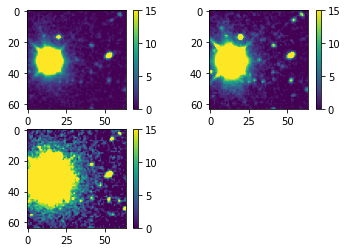

The above image is an artifact
Image plotted with a threshold magnitude of  24.159550594809588


In [10]:
Image_plot()

### Data Augmnetation 

In [11]:
# Create an ImageDataGenerator with horizontal and vertical flipping enabled
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

# Fit the data generator to the training data (X). This computes the required statistics.
datagen.fit(X)

# Fit the data generator to the validation data (X_Val). This ensures consistent data transformations.
datagen.fit(X_Val)


### Hyper parameters

In [12]:
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 16
num_heads = 12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [512, 128]  # Size of the dense layers of the final classifier

## Vision Transformer 

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [14]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [16]:
def get_config(self):

    config = super().get_config().copy()
    config.update({
        'vocab_size': self.vocab_size,
        'num_layers': self.num_layers,
        'units': self.units,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dropout': self.dropout,
    })

#### Compiling the Transformer

In [17]:
def LSBG_VT():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
LSBG_Detector = LSBG_VT()

2022-11-24 14:22:25.237103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:22:25.237272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:22:25.237366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:22:25.237809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 14:22:25.237908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [19]:
lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,decay_steps=10000,decay_rate=0.9)
opt1=tf.keras.optimizers.Adam(learning_rate=lr_schedule1, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

LSBG_Detector.compile(optimizer=opt1, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])

In [20]:
LSBG_Detector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 patches (Patches)              (None, None, 48)     0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 16)      4880        ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 16)     32          ['patch_encoder[0][0]']          
 alization)                                                                                   

                                                                                                  
 add_6 (Add)                    (None, 256, 16)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 256, 16)     32          ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 256, 32)      544         ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6 (Dropout)            (None, 256, 32)      0           ['dense_7[0][0]']                
          

In [21]:
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15,verbose=1,mode='auto',baseline=None,restore_best_weights=True)

## Training the LSBG ViT model

In [23]:
LSBG_Detector.fit(datagen.flow(X,Y),epochs=5,validation_data=datagen.flow(X_Val,Y_Val),batch_size=128,verbose=1,callbacks=e_stop,shuffle=True) #Training the network with 10% of training

Epoch 1/5
1094/1094 [==============================] - 86s 78ms/step - loss: 0.4961 - accuracy: 0.7856 - auc: 0.8498 - val_loss: 0.3952 - val_accuracy: 0.8620 - val_auc: 0.9218
Epoch 2/5
1094/1094 [==============================] - 87s 80ms/step - loss: 0.4030 - accuracy: 0.8372 - auc: 0.8992 - val_loss: 0.3180 - val_accuracy: 0.8860 - val_auc: 0.9405
Epoch 3/5
1094/1094 [==============================] - 87s 79ms/step - loss: 0.3439 - accuracy: 0.8627 - auc: 0.9255 - val_loss: 0.2933 - val_accuracy: 0.8880 - val_auc: 0.9506
Epoch 4/5
1094/1094 [==============================] - 85s 78ms/step - loss: 0.3188 - accuracy: 0.8746 - auc: 0.9350 - val_loss: 0.2671 - val_accuracy: 0.8960 - val_auc: 0.9564
Epoch 5/5
1094/1094 [==============================] - 86s 78ms/step - loss: 0.2997 - accuracy: 0.8841 - auc: 0.9417 - val_loss: 0.2627 - val_accuracy: 0.8956 - val_auc: 0.9601


In [24]:
LSBG_history = LSBG_Detector.fit(datagen.flow(X,Y),epochs=150,validation_data=datagen.flow(X_Val,Y_Val),batch_size=128,verbose=1,callbacks=e_stop,shuffle=True) #Training the network with 10% of training

Epoch 1/150
1094/1094 [==============================] - 86s 79ms/step - loss: 0.2825 - accuracy: 0.8919 - auc: 0.9477 - val_loss: 0.2509 - val_accuracy: 0.9044 - val_auc: 0.9599
Epoch 2/150
1094/1094 [==============================] - 85s 77ms/step - loss: 0.2725 - accuracy: 0.8967 - auc: 0.9506 - val_loss: 0.2481 - val_accuracy: 0.9100 - val_auc: 0.9614
Epoch 3/150
1094/1094 [==============================] - 84s 77ms/step - loss: 0.2660 - accuracy: 0.8999 - auc: 0.9524 - val_loss: 0.2465 - val_accuracy: 0.9092 - val_auc: 0.9611
Epoch 4/150
1094/1094 [==============================] - 84s 77ms/step - loss: 0.2569 - accuracy: 0.9036 - auc: 0.9555 - val_loss: 0.2357 - val_accuracy: 0.9136 - val_auc: 0.9629
Epoch 5/150
1094/1094 [==============================] - 84s 77ms/step - loss: 0.2529 - accuracy: 0.9063 - auc: 0.9560 - val_loss: 0.2333 - val_accuracy: 0.9132 - val_auc: 0.9637
Epoch 6/150
1094/1094 [==============================] - 85s 77ms/step - loss: 0.2505 - accuracy: 0.9070 

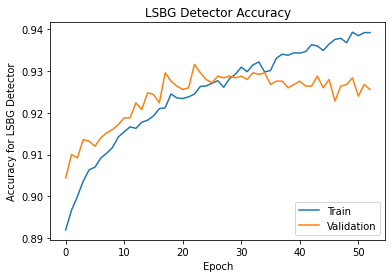

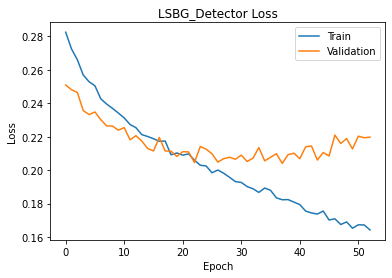

In [25]:
plt.plot(LSBG_history.history['accuracy'])
plt.plot(LSBG_history.history['val_accuracy'])
plt.title('LSBG Detector Accuracy')
plt.ylabel('Accuracy for LSBG Detector')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(LSBG_history.history['loss'])
plt.plot(LSBG_history.history['val_loss'])
plt.title('LSBG_Detector Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Testing the LSBG ViT Model on the Test Data

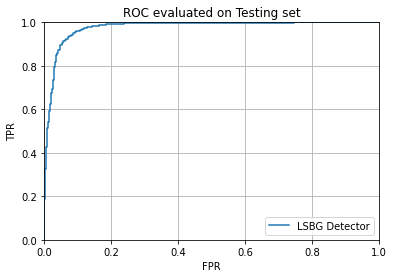

The area under the ROC curve is  0.9768367475102088
26/26 [==============================] - 2s 78ms/step - loss: 0.1798 - accuracy: 0.9332 - auc: 0.9767


[0.17977462708950043, 0.9332312345504761, 0.9766975045204163]

In [26]:
# Make predictions on the test set using the 'LSBG_Detector' model
X_test_pred = LSBG_Detector.predict(X_test)

# Calculate the ROC curve and get the False Positive Rate (frp), True Positive Rate (tpr), and Threshold (thr)
frp_transformer, tpr_transformer, thr_transformer = roc_curve(Y_test, X_test_pred)

# Plot the ROC curve for the 'LSBG Detector'
plt.plot(frp_transformer, tpr_transformer, label='LSBG Detector')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc=4)
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC (Receiver Operating Characteristic) evaluated on Testing set')
plt.grid(True)  # Show grid lines on the plot
plt.show()

# Calculate and print the Area Under the ROC Curve (AUC)
print('The area under the ROC curve is', roc_auc_score(Y_test, X_test_pred))

# Evaluate the 'LSBG_Detector' model on the test set and print the results
LSBG_Detector.evaluate(X_test, Y_test, batch_size=128, verbose=1)


### Checking the prediction probability 

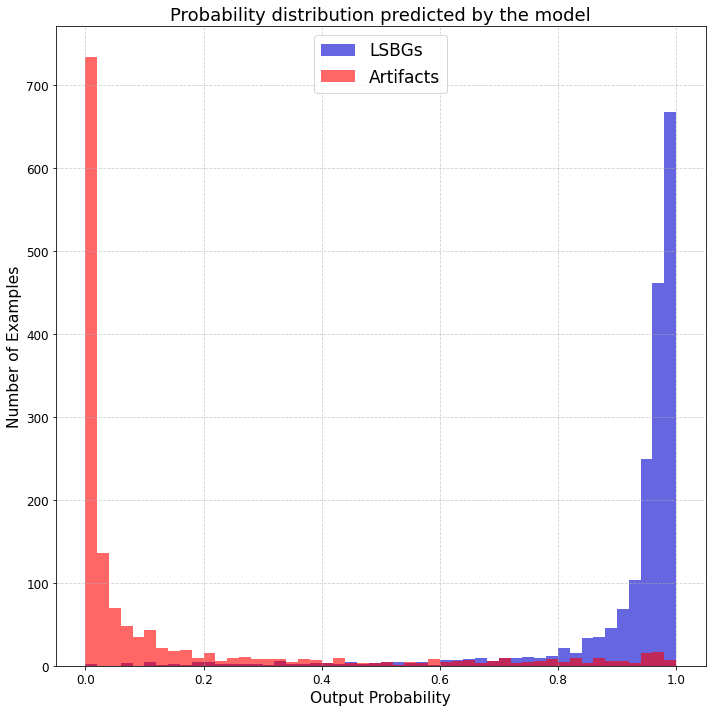

In [27]:
# Create a new figure with a specific size
plt.figure(figsize=(10, 10))

# Plot histograms for predicted probabilities of 'LSBGs' (label 1) and 'Artifacts' (label 0)
# Set the range, number of bins, colors, transparency, density, and labels
plt.hist(X_test_pred[Y_test == 1], range=[0, 1], bins=50, color='mediumblue', alpha=0.6, density=False, label='LSBGs')
plt.hist(X_test_pred[Y_test == 0], range=[0, 1], bins=50, color='red', alpha=0.6, density=False, label='Artifacts')

# Add grid lines
plt.grid(ls='--', alpha=0.6)

# Adjust tick label sizes
plt.tick_params(axis='both', labelsize=12)

# Add legend with frame, location, and font size
plt.legend(frameon=True, loc='upper center', fontsize=17)

# Set the x-axis label and y-axis label, and title for the plot
plt.xlabel("Output Probability", fontsize=15.5)
plt.ylabel("Number of Examples", fontsize=15.5)
plt.title("Probability distribution predicted by the model", fontsize=18)

# Ensure a tight layout
plt.tight_layout()

# Show the plot
plt.show()


### Confusion Matrix 

The Accuracy of the model is  0.9347626339969373
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1401
           1       0.93      0.96      0.94      1864

    accuracy                           0.93      3265
   macro avg       0.94      0.93      0.93      3265
weighted avg       0.94      0.93      0.93      3265

[[1263  138]
 [  75 1789]]


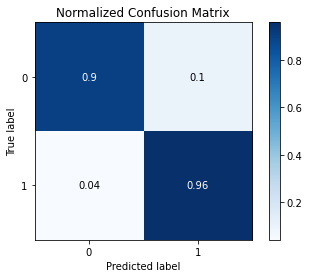

In [81]:
# Initialize an empty list to store Transformer results
Transformer_Result = []

# Loop through the predicted probabilities (X_test_pred) for each example in the test set
for i in range(0, len(X_test_pred)):
    if X_test_pred[i] > 0.6:
        y = 1  # Assign 1 if predicted probability is greater than 0.6
    if X_test_pred[i] < 0.6:
        y = 0  # Assign 0 if predicted probability is less than 0.6
    Transformer_Result.append(y)  # Append the result to the list

# Calculate and print the accuracy of the model
print("The Accuracy of the model is", accuracy_score(Y_test, Transformer_Result))

# Generate and print a classification report
print(classification_report(Y_test, Transformer_Result))

# Generate and print a confusion matrix
print(confusion_matrix(Y_test, Transformer_Result))

# Plot a normalized confusion matrix
skplt.metrics.plot_confusion_matrix(Y_test, Transformer_Result, normalize=True)
plt.show()


In [29]:
# Save the weights of the 'LSBG_Detector' model to a file
# Replace '............................/LSBG_Vision' with the actual file path where you want to save the weights
LSBG_Detector.save_weights(r'............................/LSBG_Vision', overwrite=True)


### Using the model

Compile the model as shown above. After compiling the model load the trained weights to the compiled model. 

In [ ]:
# Load the weights into the 'LSBG_Detector' model from a file
# Replace '............................/LSBG_Vision' with the actual file path where the model weights are stored
LSBG_Detector.load_weights(r'............................/LSBG_Vision')
